# On Suicidality Subject Matter Detection

The purpose of this study is to create a predictive model that assesses text and detects in its subject matter content that relates to suicidality, and to examine the ways in which the results can facilitate analysis and prevention.

### Table of Contents:

- Part I: Introduction
- Part II: Preprocessing Summary
- Part III: EDA Summary
- Part IV: Predictive Model and Relevant Findings
- Part V: Streamlit Application
- Part VI: Conclusion

## Part I: Introduction

While sufferers of depression are not and must not be assumed inherently suicidal, it can often serve as a contributing cause in suicidality. Thus, questions arise: Can reliable means be developed to detect distinctions between subject matter authored by sufferers of depression or that remains within the threshold of depression and subject matter that crosses a threshold into suicidality, or at least whose focus is suicidality? What would such means looks like, and to what uses might we use them? Most importantly, how might the development and improvement of such detection aid in future suicide prevention?

This study aims primarily to lay a foundation for answering these questions by developing a functional predictive model that can distinguish reliably between text bodies on either side of this threshold (i.e. depression and suicidality) and to allow the findings and corrollary Streamlit application to act as a stepping stone for further inquiry.

It must be stated that nothing within this study ought to be taken as the equivalent of or a substitute for real licensed medical treatment. 

During the course of this project, the data (consisting of text posts collected by Nikhileswar Komati from `r/SuicideWatch` and `r/depression` using the PushShift API) was fit to many binary classification models, in a variety of forms, or having undergone a variety of different "versions" of preprocessing. Though the initial plan was to employ two final models (one for interpretability and on for sheer predictive power), in the end the model that proved the most accurate also lends itself more than the others to actionable interpretation. More on this model can be found below.


## Part II: Preprocessing Summary

The notebooks in which preprocessing work was done for this project can be found in `appendices/preprocessing/`, but a brief summary will be offered here. The initial dataset used is a collection of over 700,000 combined entries from the `r/SuicideWatch` and `r/depression` subreddits, gathered by user Nikhileswar Komati using the PushShift API.

First, relevant text data was combined and parsed, with null entries being removed due to the large size of the dataset. The target column (`Subreddit`) was converted to a binary integer column for modeling purposes, and after parsing the text of problematic characters, it was converted separately to two separate feature columns (`lower`, or the combined text made lower case, and `unstopped`, identical to the `lower` column but with English stopwords removed).

These steps are recorded in `01_initial_cleaning.ipynb` of the forementioned directory and subdirectory.

What followed was a great effort to create multiple forms of each text, with each form serving as a potential feature, so that all versions could see the modeling phase and the one that offered the best accuracy could be used in the final model. Ultimately, eight different versions of the text data were created:

- words only, made lowercase, lemmatized
- words only, made lowercase, stemmed
- words made lowercase and potentially significant digits, lemmatized
- words made lowercase and potentially significant digits, stemmed
- words only with English stopwords removed, made lowercase, lemmatized
- words only with English stopwords removed, made lowercase, stemmed
- words made lowercase (with English stopwords removed) and potentially significant digits, lemmatized
- words made lowercase (with English stopwords removed) and potentially significant digits, stemmed

The generation of these features is again recorded in `appendices/preprocessing/`, in the following notebooks:

- `02_cleaning_lower_lemm.ipynb`
- `03_cleaning_unstopped_lemm.ipynb`
- `04_cleaning_lower_stem.ipynb`
- `05_cleaning_unstopped_stem.ipynb`

The notebook that records exploratory analysis for this project is `06_initial_eda.ipynb`, and of the eight notebooks in. the `preprocessing` subdirectory, it is the one that stands out as having markdown included for explanation. (The other notebooks are largely self-explanatory, with very simple code actions taken, and what little explanation is necessary is offered here).

As the exploratory phase is best treated separately from initial cleaning, more notes on this notebook are included below.

With the eight features (or eight versions of the same feature) created, it became most reasonable to combine them into a single dataset, and this was done in `07_full_dataset.ipynb`. The file that gets exported in the last cell is the most robust and comprehensive version of the relevant data for this project. However, because of its sheer size, computational limits and RAM limits made it necessary in the early stages of modeling to down sample significantly, and the significantly smaller (though still large) down-sampled dataset was created in `08_down_sample.ipynb`. This ultimately became the "official" dataset of the modeling phase.

## Part III: EDA

The exploratory phase of this study was done for the most part in conjunction with the projects first check-in deadline, and for that reason, the relevant notebook (`06_initial_eda.ipynb`) is marked down in great deal with what was discovered. Very briefly though, the most notable finding was the significantly shorter length of posts to `r/SuicideWatch` on average than to `r/depression`. Both in terms of word count and character count, posts to `r/depression` were roughly 10 to 20% longer than posts to `r/SuicideWatch`. What this might mean could invite further inquiry as part of a future project.

## Part IV: Predictive Model and Relevant Findings

Many versions of the data were fit to many models. The directory `appendices/modeling` contains over twenty notebooks whose shared purpose was simply to find the best model for the best version of the available data to obtain the most reliable results possible.

All eight versions of the preprocess text data were fit. Models included logistic regression, Gradient Boosting, AdaBoost, random forests, multinomial naive Bayes, Bernoulli naive Bayes, and neural networks. The running of these models, their scores and outputs can be found in notebooks `01` through `13` of the `modeling` subdirectory. 

Toward the end of the modeling phase, high training scores for random forests and neural networks led to more extensive attempts at fine-tuning, to see if this or that combination of hyperparameters might give the test data a significant jump. (See `14` through `19` in `modeling`.) Ultimately though, logistic regression outperformed these and all the others, making it the strongest model of all both for predictive capacity and interpretability. 

Due to RAM limitations, gridsearching multiple vectorized dataframes to fine-tune the final logistic regression model was not feasible. This led to testing hyperparameter combinations for vectorizing the text one at a time and finally settling on the best result. (See `20` in `modeling`.) Finally, the final polishing of the logistic regression parameters is found in `21` of `modeling`, and in the end, the default variables gave the best score for the test data.

Initial imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

Mounting drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading in dataset. The best-performing version of the text data proved to be words-only, lemmatized, with English stopwords removed:

In [3]:
df = pd.read_csv('/content/drive/MyDrive/down_sample.csv')[['Subreddit', 'unst_simp_lem']]

Divvying input and output columns:

In [4]:
X = df.drop(columns='Subreddit')
y = df['Subreddit']

X_train, X_test, y_train, y_test=train_test_split(X, y, stratify = y, random_state=42)

`TfidfVectorizer` proved the most accurate. Vectorization below, with best hyperparameters included:

In [5]:
tvec = TfidfVectorizer(min_df=5, max_df=0.80, ngram_range=(1,3))
tvec.fit(X_train['unst_simp_lem'])
X_train_tv = pd.DataFrame(tvec.transform(X_train['unst_simp_lem']).todense(), columns = tvec.get_feature_names())
X_test_tv = pd.DataFrame(tvec.transform(X_test['unst_simp_lem']).todense(), columns = tvec.get_feature_names())

Model instantiated and fit in the cells that follow. Again, as it turned out, the default hyperparameter settings offered the highest test score:

In [6]:
lr = LogisticRegression()

In [7]:
lr.fit(X_train_tv, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
lr.score(X_train_tv, y_train)

0.8848444444444444

In [9]:
lr.score(X_test_tv, y_test)

0.7974666666666667

In [10]:
cross_val_score(lr, X_train_tv, y_train, cv=5).mean()

0.7886222222222223

The score nears the 80% cusp for accuracy, against a 50% baseline (the subreddits are represented evenly both in the initial and final dataset). 

Because of the nature of the question this study seeks to answer, recall scores are arguably more significant than accuracy scores, or they could be potentially for any scenario in which the goal is detection of suicidality. That is, avoiding false negatives, or missing cases of suicidality, could be paramount. (Again, this study does not claim to have finalized a model that can be put to this purpose, nor is it a proxy for actual diagnoses.)

Throughout the modeling process, recall scores tended to correlate generally with their respective accuracy scores. Models with better accuracy had better recall scores and vice versa.

It is beyond the scope of this study to determine the "ideal" balance between accuracy and recall. A question of that magnitude requires great care and only the most judicious methods of inquiry. However, the Streamlit application (discussed in the section below), was developed with the fine-tuning of these metrics in mind. For this section, a brief confusion matrix is included to give a sense of how recall looks:

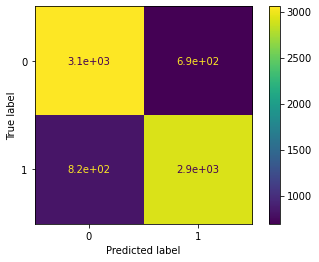

In [13]:
cm = confusion_matrix(y_test, lr.predict(X_test_tv))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
disp.plot();

For a more thorough treatment of takeaways that this model provides, see `presentation.pdf`, included in this repo. However, the comparative values of model coefficients for the vectorized data offer some insights. The most significant terms that might lead to a positive classification (or, a classification of containing subject matter related to suicidality) turn out to be terms that seem directly related to dying, isolation, and feelings of worthlessness.

## Part V: Streamlit Application

The Streamlit application at the time of this writing is extremely rudimentary, but also built according to a design that invites future expansion. Its main function is to take in a body of text from the user as well as a specified probability threshold.

This threshold allows the user to optimize according to any predetermined probability of his or her choosing that the text being submitted contains subject matter related to suicidality, according to the model. Again, the purpose is to allow the user to adjust for optimal recall (so to speak), based on the limit deemed most appropriate for the use case in question.

The model is called neatly, and is coded in such a way that should a future model perform better, it can be easily swapped in.

An `About` page is included, so that if the project ever expands, more authors can be added, along with their contact information so that users can consult them according to their respective areas of expertise. Finally, a `Resources` page is included, to which more items can be added, for anyone seeking more information on suicide prevention.

## Part VI: Conclusion

Finally, the model works. Its implications are again somewhat unclear and would require further inquiry to iron out. Suicidality as subject matter can be said to be reliably detectable, but to what degree does suicidality as subject matter correlate with suicidality as such? This is a fair question, but a cursory perusal of the data suggest that the correlation in many cases is indeed present. More data from additional sources could fit to a model to make it more well-rounded, helping to bolster its predictive power in relation to a somewhat nebulous concept. 

Could further developments connect specific terms with higher coefficients to known warning signs of suicidality, so that users might receive an output of what to read for in their input? This might be possible, but it also enters the realm of "diagnosis", and therefore must be treated with the greatest caution. Could known cases of suicide provide data that might be fit to time series models? Again, sensitivty to unforeseen externalities is paramount.

As it stands, the model and the Streamlit app form a foundation on which to build in exploring further.